In [2]:
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

from exputils.state.random import make_random_quantum_state
from exputils.state.tensor import make_random_tensor_product_state
from exputils.perm_Amat import get_perm_Amat, tensor_product_in_perm_basis
from exputils.perm_dot import compute_all_dot_products_perm
from exputils.RoM.custom import calculate_RoM_custom
from exputils.math.partitions import partitions
from exputils.eff_kron_perm_Amat import eff_kron_perm_Amat
from exputils.RoM.dot import get_topK_indices

In [3]:
class PermOptRes:
    def __init__(self, n, RoM, coeff, opt_perm_Amat):
        self.n = n
        self.RoM = RoM
        self.coeff = coeff
        self.opt_perm_Amat = opt_perm_Amat

    def __mul__(self, other):
        n = self.n + other.n
        RoM = self.RoM * other.RoM
        coeff = np.kron(self.coeff, other.coeff)
        opt_perm_Amat = eff_kron_perm_Amat(
            self.n, self.opt_perm_Amat, other.n, other.opt_perm_Amat
        )
        return self.__class__(n, RoM, coeff, opt_perm_Amat)

    def __repr__(self):
        return f"PermOptRes(n={(str(self.n) + ',').ljust(3)} RoM={self.RoM:.7f}, shape={self.opt_perm_Amat.shape})"


eps = 10**-12


def optimize(n, perm_Amat, single_rho):
    perm_rho = tensor_product_in_perm_basis(single_rho, n)
    RoM, coeff = calculate_RoM_custom(perm_Amat, perm_rho, method="gurobi")
    basic_indices = abs(coeff) > eps
    basic_coeff = coeff[basic_indices]
    opt_perm_Amat = perm_Amat[:, basic_indices]
    return PermOptRes(n, RoM, basic_coeff, opt_perm_Amat)

In [4]:
sns.set_theme("paper")
sns.set(font_scale=1.5)


def plot_result(ns_exact, RoMs_exact, ns_approx, RoMs_approx):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ns_list = [ns_exact, ns_approx]
    RoMs_list = [RoMs_exact, RoMs_approx]
    labels = ["Exact", "Approximate"]
    for ns, RoMs, label in zip(ns_list, RoMs_list, labels):
        sns.scatterplot(x=ns, y=RoMs, label=label, linewidth=0, marker="o", ax=ax)

    ax.set_yscale("log")
    ax.set_xlabel("n", fontsize=20)
    ax.set_ylabel("RoM", fontsize=20)
    ax.set_ylim(ymin=0.9)

    plt.savefig(
        "permutation_symmetry_approximate.pdf",
        bbox_inches="tight",
    )

    # plt.tight_layout()
    # plt.show()

In [5]:
seed = 0
single_rho = make_random_quantum_state("mixed", 1, seed)
# single_rho = make_random_tensor_product_state("H", 1, seed)

In [6]:
# precalculation with 1 <= n <= 6

perm_opt_res_list = [None]
for n in range(1, 6 + 1):
    perm_Amat = get_perm_Amat(n)
    res = optimize(n, perm_Amat, single_rho)
    perm_opt_res_list.append(res)

Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-16


In [7]:
# precalculation with n = 7


def cg(
    perm_opt_res_list,
    n=7,
    K=0.005,
    iter_max=100,
    violation_max=100000,
    discard_current_threshold=0.9,
):
    perm_Amat = get_perm_Amat(n)
    perm_rho = tensor_product_in_perm_basis(single_rho, n)

    rho_dots = compute_all_dot_products_perm(n, perm_rho)
    indices = get_topK_indices(rho_dots, K)
    current_Amat = perm_Amat[:, indices]
    for it in range(iter_max):
        print(f"{it = }, # of columns = {current_Amat.shape[1]}")
        RoM, coeff, dual = calculate_RoM_custom(
            current_Amat, perm_rho, method="gurobi", return_dual=True
        )
        print(f"{RoM = }")
        dual_dots = np.abs(compute_all_dot_products_perm(n, dual))
        dual_violated_indices = dual_dots > 1 + eps
        violated_count = np.sum(dual_violated_indices)

        print(f"# of violations: {violated_count}")
        if violated_count == 0:
            break
        elif violated_count <= violation_max:
            indices = np.where(dual_violated_indices)[0]
            extra_Amat = perm_Amat[:, indices]
        else:
            raise Exception("Too many violations")

        # restrict current Amat
        nonbasic_indices = np.abs(coeff) > eps
        critical_indices = np.abs(dual @ current_Amat) >= (
            discard_current_threshold - eps
        )
        remain_indices = np.logical_or(nonbasic_indices, critical_indices)
        restricted_current_Amat = current_Amat[:, remain_indices]

        current_Amat = hstack((restricted_current_Amat, extra_Amat))

    basic_indices = abs(coeff) > eps
    basic_coeff = coeff[basic_indices]
    opt_perm_Amat = current_Amat[:, basic_indices]
    res = PermOptRes(n, RoM, basic_coeff, opt_perm_Amat)
    perm_opt_res_list.append(res)

it = 0, # of columns = 90033
RoM = 4.362123255333906
# of violations: 1981
it = 1, # of columns = 2889
RoM = 4.359836252447135
# of violations: 49
it = 2, # of columns = 1149
RoM = 4.359829746614793
# of violations: 1
it = 3, # of columns = 1132
RoM = 4.359829712850414
# of violations: 0


In [8]:
perm_opt_res_list

[None,
 PermOptRes(n=1,  RoM=1.3931841, shape=(4, 4)),
 PermOptRes(n=2,  RoM=1.6485916, shape=(10, 10)),
 PermOptRes(n=3,  RoM=1.9988133, shape=(20, 20)),
 PermOptRes(n=4,  RoM=2.4252194, shape=(35, 35)),
 PermOptRes(n=5,  RoM=2.9447814, shape=(56, 56)),
 PermOptRes(n=6,  RoM=3.5882409, shape=(84, 84)),
 PermOptRes(n=7,  RoM=4.3598297, shape=(120, 120))]

In [9]:
# extension
def extend(perm_opt_res_list):
    n = len(perm_opt_res_list)
    kron_Amats = []
    for smaller_n in range(1, n // 2 + 1):
        larger_n = n - smaller_n
        kron_opt_perm_Amat = perm_opt_res_list[smaller_n] * perm_opt_res_list[larger_n]
        kron_Amats.append(kron_opt_perm_Amat.opt_perm_Amat)
    hstacked_Amat = hstack(kron_Amats)
    del kron_Amats
    # eliminate duplicate columns
    rng = np.random.default_rng(0)
    rv = rng.integers(low=1e-18, high=1e18, size=hstacked_Amat.shape[0])
    dots = rv @ hstacked_Amat
    _, indices = np.unique(dots, return_index=True)
    del dots
    perm_Amat = hstacked_Amat[:, indices]
    del indices
    res = optimize(n, perm_Amat, single_rho)
    perm_opt_res_list.append(res)

PermOptRes(n=8,  RoM=5.2817954, shape=(165, 165)) [8.481012727659747e-07, 2.4264554222648213e-06, 5.614274472254332e-06, 9.964969103878119e-06, 1.1116374288367044e-05]
PermOptRes(n=9,  RoM=6.3852320, shape=(220, 220)) [2.74155064518476e-07, 1.0674588824252057e-06, 1.4165945363148885e-06, 2.1445297860954723e-06, 2.5247832420109673e-06]
PermOptRes(n=10, RoM=7.6980734, shape=(286, 286)) [2.419730410427305e-07, 4.591550490424304e-07, 9.976276873692457e-07, 1.2769854031994262e-06, 1.8479579257158185e-06]
PermOptRes(n=11, RoM=9.2716392, shape=(364, 364)) [1.6054009850647874e-07, 4.976464173930997e-07, 5.384632540986643e-07, 5.485714298060477e-07, 5.58152122580379e-07]
PermOptRes(n=12, RoM=11.1594170, shape=(455, 455)) [8.400236733226616e-09, 1.1397678143301726e-08, 1.8520744613714385e-08, 2.133685370817304e-08, 3.818147768746322e-08]
PermOptRes(n=13, RoM=13.4559940, shape=(560, 560)) [2.7906866649287266e-10, 6.75375312949333e-08, 1.1303784085836246e-07, 1.1653939642418575e-07, 1.300034200116

/home/meip-users/ドキュメント/Programs/stabilizer_simulator/exputils/RoM/custom.py:123: UserWarning: RoM calculation failed. (rho_vec.shape=(969,),custom_Amat.shape=(969, 60028))
  warnings.warn(


TypeError: 'float' object is not subscriptable

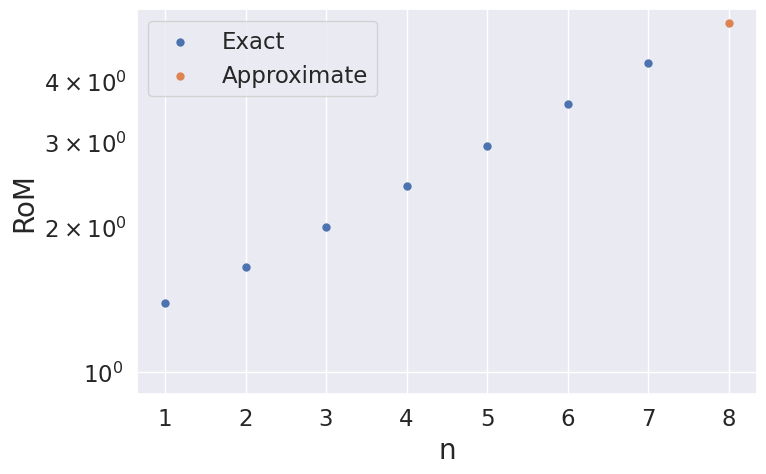

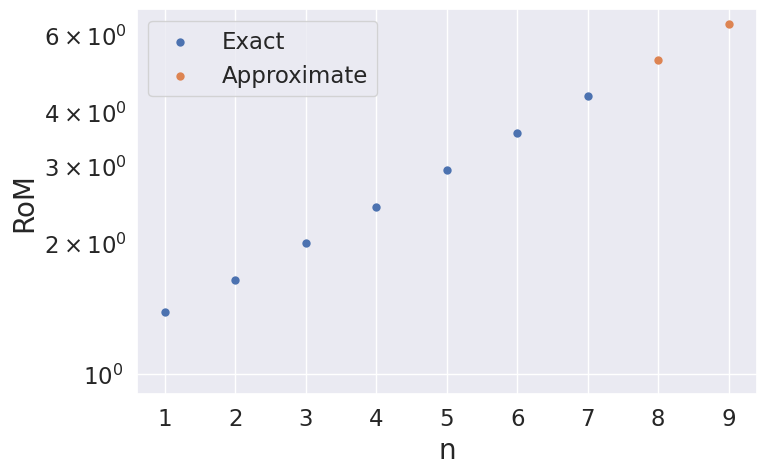

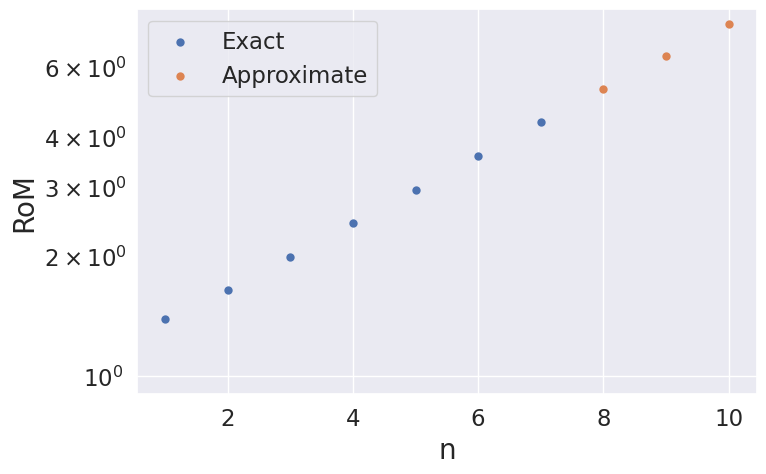

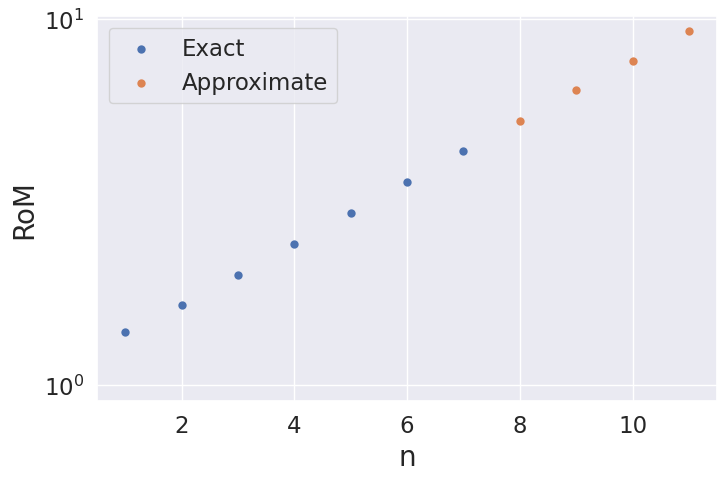

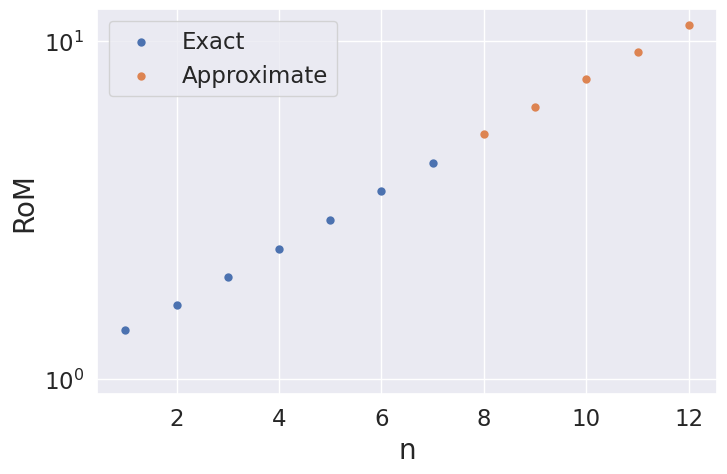

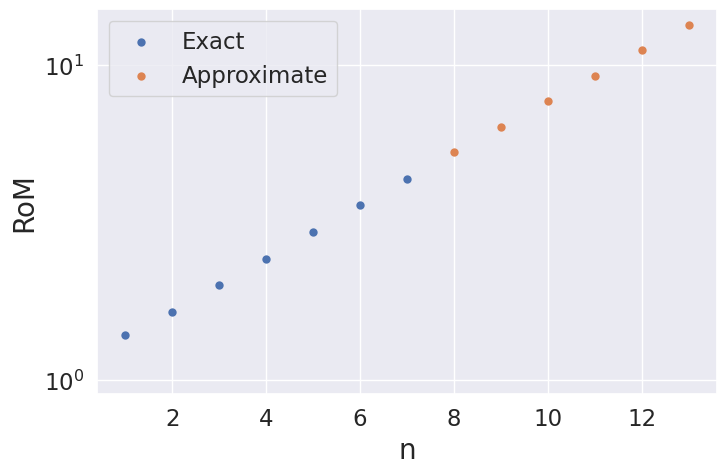

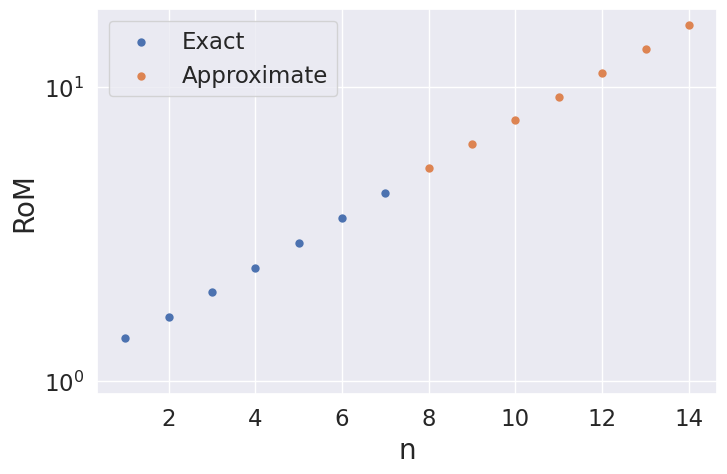

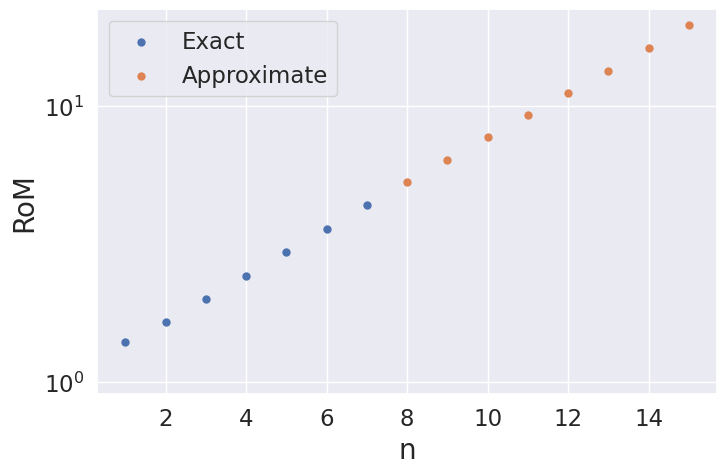

In [10]:
while len(perm_opt_res_list) < 26:
    extend(perm_opt_res_list)
    ns_exact = list(range(1, 7 + 1))
    ns_approx = list(range(7 + 1, len(perm_opt_res_list)))
    RoMs_exact = [perm_opt_res_list[n].RoM for n in ns_exact]
    RoMs_approx = [perm_opt_res_list[n].RoM for n in ns_approx]
    plot_result(ns_exact, RoMs_exact, ns_approx, RoMs_approx)
    with open("result.txt", "w") as f:
        for res in perm_opt_res_list[1:]:
            print(res.n, res.RoM, file=f)
    print(res, sorted(np.abs(res.coeff))[:5])